In [286]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.datasets import electrocardiogram
from scipy.signal import find_peaks, argrelmin, find_peaks_cwt
import pandas as pd
from collections import Counter
from scipy import signal

In [287]:
from sklearn.linear_model import SGDRegressor 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 


from sklearn.pipeline import make_pipeline


In [288]:
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a001/a001.initial.Calibration_start_3.tsv"
path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a002/a002.initial.Static_seated_challenge_1.tsv"
#path ="/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a004/a004.initial.Exercise_challenge_start_1.tsv"
#path = "/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a000/a000.initial.Static_challenge_start_1.tsv"


#path ="/Users/cslinxs/Desktop/all_weeks/aurorabp-sample-data/sample/measurements_auscultatory/a000/a000.initial.Static_seated_challenge_1.tsv"

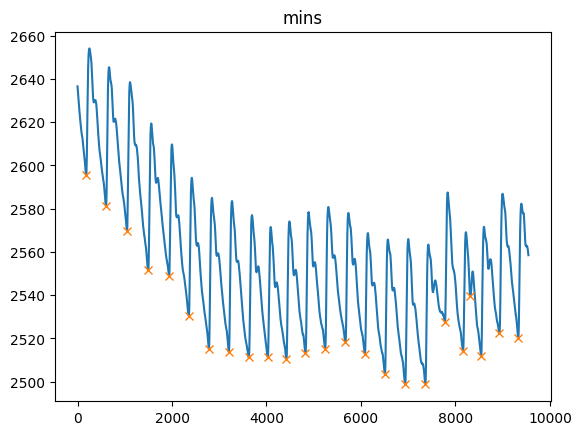

In [289]:

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

neglist = [ -x for x in pos_pressure]

min_peaks, _ = find_peaks(neglist, prominence=10)


plt.plot(pos_pressure)
plt.plot(min_peaks, pos_pressure[min_peaks], "x")
plt.title("mins")
plt.show()


<class 'numpy.ndarray'>


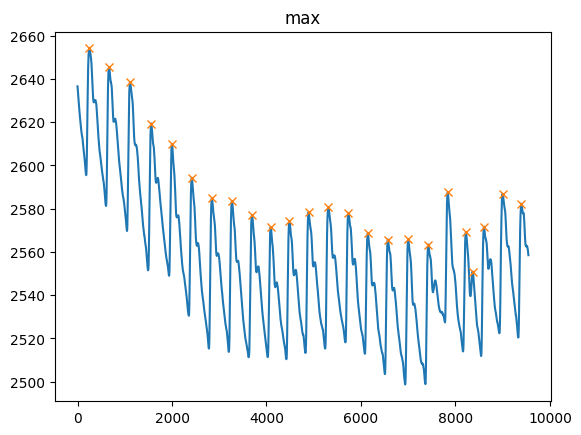

In [290]:

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


max_peak, _ = find_peaks(pos_pressure, prominence=10)

plt.plot(pos_pressure)
print(type(max_peak))
plt.plot(max_peak, pos_pressure[max_peak], "x")
plt.title("max")

plt.show()

In [291]:
#this is so i can see the diffrences in the graph widths
diffrences_min = np.diff(min_peaks)
mean_min = float(diffrences_min.mean())

diffrences_max = np.diff(max_peak)
mean_max = float(diffrences_max.mean())


print(mean_min,mean_max )

397.5652173913044 397.4782608695652


In [292]:
#this edeleuets all elemerns with in 40 of the mini
need_to_go  = []

set_max_peak = set(max_peak)
for mini in list(min_peaks):
    if len(set(range(mini-40,40+mini)).intersection(set_max_peak))>0:
        need_to_go.append(int(mini))

combo_list =  list(min_peaks)+ (need_to_go)
combo_list = [int(i) for i in combo_list]

# juts deleted stuff from both lists if its in tht 40 range
new_mins = [k for k,v in Counter(combo_list).items() if v==1]



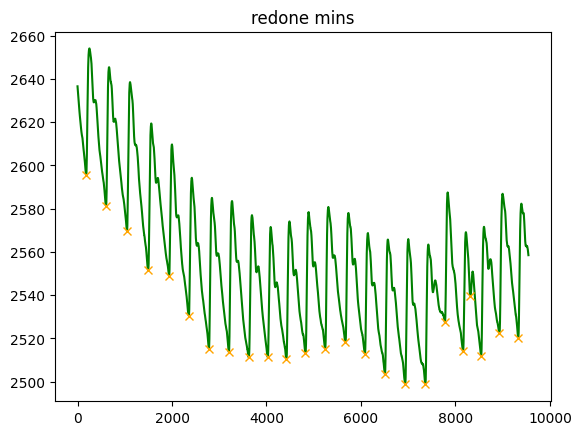

In [293]:

#fileted ghrough mins
df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]


plt.plot(pos_pressure, color="green")


newst_mins= np.asarray(list(new_mins), dtype=np.float32)

plt.plot(newst_mins, pos_pressure[newst_mins], "x", color="orange")
plt.title("redone mins")

plt.show()

This the diffrence in means:

In [294]:
#print(min_peaks,peaks)
diffrences_min = np.diff(min_peaks)

mean_min = float(diffrences_min.mean())

diffrences_max = np.diff(max_peak)

mean_max = float(diffrences_max.mean())


diffrences_new_min = np.diff(newst_mins)

mean_new_min = float(diffrences_new_min.mean())


print(mean_min,mean_max,mean_new_min )


397.5652173913044 397.4782608695652 397.5652160644531


In [295]:
diffrences_new_min

array([419., 444., 446., 445., 418., 425., 421., 419., 405., 394., 404.,
       416., 430., 412., 424., 428., 428., 414., 384., 156., 226., 386.,
       400.], dtype=float32)

In [296]:
# here i think if i get the stats of the list i can ssee if something is weird and drop the point
#  BUTTTT HERE IS WHERE I SEE WHAT POINT HAS TO GO

def get_stats(check_list):
    standard = float(np.std(check_list))
    mean = float(np.mean(check_list))
    return [min(check_list),mean-standard-standard,mean-standard,mean,mean + standard,mean +standard+standard ,max(check_list) ]
get_stats(diffrences_new_min)[5]

530.7755126953125

here is where i wanna remvoe the things tooo far away frommthe mena

so i will say noise is when the chatr is showing a beat within 20 mins of another

if something is 20+- another beat in the other list it is removed

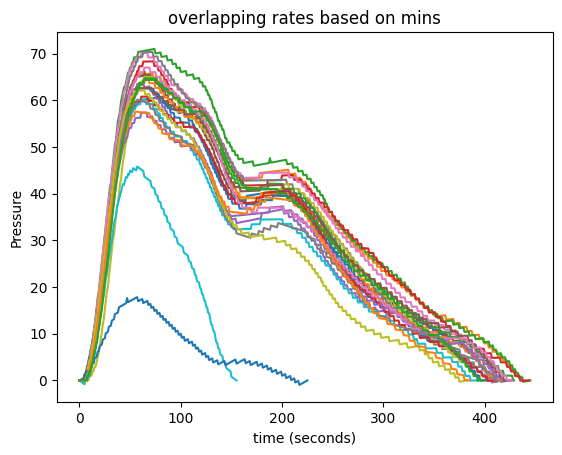

In [297]:
all_overlaps = [[] for i in range(int(max(diffrences_new_min)))]

df = pd.read_csv(path,sep = '\t')   
pos_pressure = df["pressure"]

newst_mins= np.asarray(list(new_mins), dtype=np.float32)

mini_list = list(newst_mins)

for i in range(len(mini_list)-1):

    if (int(mini_list[i+1]) -int(mini_list[i]))< get_stats(diffrences_new_min)[4] :
        y_range  = list(range(int(mini_list[i]),int(mini_list[i+1])))
        y_of_shift = [int(y - min(pos_pressure[y_range])) for y in pos_pressure[y_range]]

        x_range = list(range(int(mini_list[i]),int(mini_list[i+1])))
        x_of_shift = [int(x - x_range[0]) for x in x_range]
        start_end_line = np.linspace(y_of_shift[0], y_of_shift[-1], len(y_of_shift), endpoint=True)

        y_rotated = [xi - yi for xi, yi in zip(y_of_shift, start_end_line)]


        for x_indi in range(len(x_range)):
            #print(x_indi)
            #all_overlaps[x_indi].append(
            all_overlaps[x_indi].append(int(y_of_shift[x_indi]-start_end_line[x_indi]))
        
        # um all_overlaps and y_rotated does the same thing... i think, it is but it has some error
        
        #plt.plot(start_end_line)
        

        plt.plot(x_of_shift, y_rotated)



plt.title("overlapping rates based on mins")
plt.ylabel("Pressure")
plt.xlabel("time (seconds)")

plt.show()

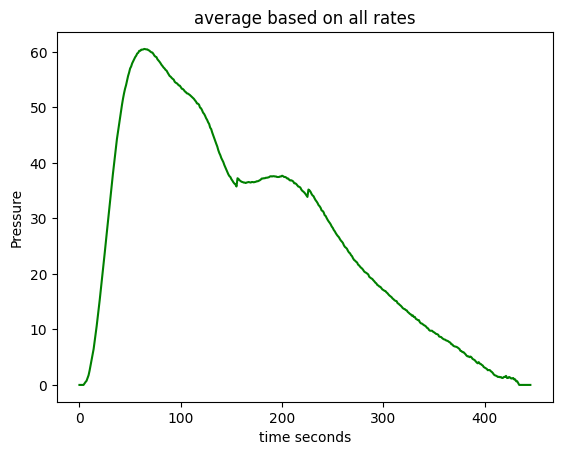

In [305]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))
plt.plot(all_overlaps_means, color='green')
plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")
contecting_it = np.linspace(all_overlaps_means[0], all_overlaps_means[-1], len(all_overlaps_means), endpoint=True)
#plt.plot(contecting_it)
plt.show()



In [306]:
print(contecting_it)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

IMPOETANPINTS

In [300]:
all_overlaps_means

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(0.2608695652173913),
 np.float64(0.5217391304347826),
 np.float64(0.7391304347826086),
 np.float64(1.2173913043478262),
 np.float64(1.7391304347826086),
 np.float64(2.5652173913043477),
 np.float64(3.5217391304347827),
 np.float64(4.434782608695652),
 np.float64(5.391304347826087),
 np.float64(6.478260869565218),
 np.float64(7.826086956521739),
 np.float64(9.130434782608695),
 np.float64(10.608695652173912),
 np.float64(12.130434782608695),
 np.float64(13.565217391304348),
 np.float64(15.304347826086957),
 np.float64(17.0),
 np.float64(18.652173913043477),
 np.float64(20.434782608695652),
 np.float64(21.956521739130434),
 np.float64(23.869565217391305),
 np.float64(25.73913043478261),
 np.float64(27.434782608695652),
 np.float64(29.217391304347824),
 np.float64(31.130434782608695),
 np.float64(32.82608695652174),
 np.float64(34.43478260869565),
 np.float64(36.21739130434783),
 np.float

In [301]:
all_overlaps_means

print(len(all_overlaps_means[0::10]))

print(all_overlaps_means)



45
[np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.2608695652173913), np.float64(0.5217391304347826), np.float64(0.7391304347826086), np.float64(1.2173913043478262), np.float64(1.7391304347826086), np.float64(2.5652173913043477), np.float64(3.5217391304347827), np.float64(4.434782608695652), np.float64(5.391304347826087), np.float64(6.478260869565218), np.float64(7.826086956521739), np.float64(9.130434782608695), np.float64(10.608695652173912), np.float64(12.130434782608695), np.float64(13.565217391304348), np.float64(15.304347826086957), np.float64(17.0), np.float64(18.652173913043477), np.float64(20.434782608695652), np.float64(21.956521739130434), np.float64(23.869565217391305), np.float64(25.73913043478261), np.float64(27.434782608695652), np.float64(29.217391304347824), np.float64(31.130434782608695), np.float64(32.82608695652174), np.float64(34.43478260869565), np.float64(36.21739130434783), np.float64(37.95652173913044), np.floa

[-3.93411059e-02  1.79730541e+00  1.18818952e+01  2.69933624e+01
  4.22809024e+01  5.29676195e+01  5.85582723e+01  6.04255430e+01
  5.98977946e+01  5.78652216e+01  5.57480349e+01  5.39040900e+01
  5.25025882e+01  5.08208336e+01  4.81629080e+01  4.40587449e+01
  3.96524043e+01  3.67402991e+01  3.65864699e+01  3.64599412e+01
  3.69351131e+01  3.74684764e+01  3.75500955e+01  3.72709684e+01
  3.60333149e+01  3.47396148e+01  3.37273506e+01  3.09581775e+01
  2.83665854e+01  2.57945297e+01  2.35239879e+01  2.13643366e+01
  1.97262808e+01  1.80023241e+01  1.66149217e+01  1.50544707e+01
  1.36235635e+01  1.22505551e+01  1.09188736e+01  9.65941669e+00
  8.63644452e+00  7.55673150e+00  6.44932786e+00  5.20510080e+00
  4.14476000e+00  2.99477887e+00  1.78234233e+00  1.35745991e+00
  1.07002134e+00  7.35831046e-03]
446


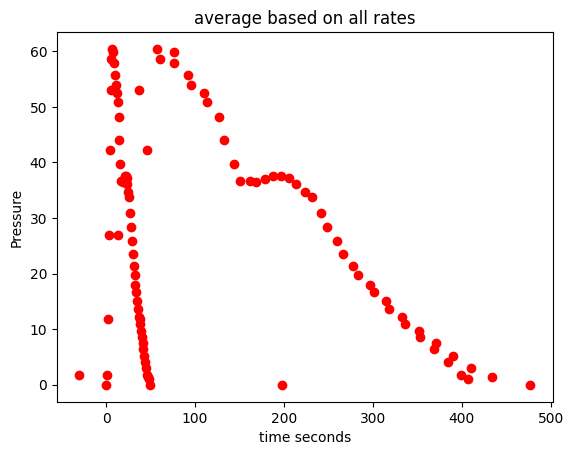

In [302]:
#to get data for the overall mean 
all_overlaps_means = []
#mean for each row
for lists in all_overlaps:
    all_overlaps_means.append(np.mean(lists))

resampled_y = signal.resample(all_overlaps_means, 50)
resampled_x = signal.resample(list(range(len(all_overlaps_means))), 50, )
print(resampled_y)

plt.plot(resampled_x,resampled_y,  'ro' )
plt.plot(resampled_y,  'ro' )
print(len(all_overlaps_means))
#plt.plot(all_overlaps_means )

plt.title("average based on all rates")
plt.ylabel("Pressure")
plt.xlabel("time seconds")

plt.show()

In [303]:
# chopped_x_points=  [ int(x) for x in all_overlaps_means[0::20] ]
# #all_overlaps_means[0::20]
# #pos_pressure[chopped_x_points]
# chopped_y_points = list(range(len(chopped_x_points)))

print(len(all_overlaps_means[0::10]))

45


all_overlaps_means[0::10]

In [304]:
X = list(all_overlaps_means[0::20]  )
y = list(range(len(chopped_x_points)))
print(X)
fitter = SGDRegressor( penalty=None)
fitter.fit(X, y)

NameError: name 'chopped_x_points' is not defined

In [ ]:
X = chopped_x_points
y = chopped_y_points

sgd = SGDRegressor()  
sgd.fit(X.reshape(-1, 1), y.reshape(-1, 1))

print("intercept=", sgd.intercept_)
print("coef=", sgd.coef_)

AttributeError: 'list' object has no attribute 'reshape'

In [ ]:

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(chopped_x_points, chopped_y_points)

ValueError: Expected 2D array, got 1D array instead:
array=[  8.11764706  26.35294118  98.17647059 140.76470588 163.47058824
 170.41176471 169.35294118 157.82352941 119.23529412  85.82352941
  77.          71.88235294  61.47058824  49.11764706  39.82352941
  32.94117647  27.17647059  22.          17.82352941  14.05882353
  10.52941176   6.52941176   2.875        1.1          0.33333333
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan          nan          nan
          nan          nan          nan].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
clf = SGDRegressor()
clf.fit(x_to_train, y_to_train)

# clf is a trained model

y_predicted = clf.predict(X_to_predict)

In [ ]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing() 
X = california.data 
y = california.target

In [ ]:
print(X[:1])

[[   8.3252       41.            6.98412698    1.02380952  322.
     2.55555556   37.88       -122.23      ]]
